### Setup

* pip3 install opencv-python
* pip3 install git+https://github.com/whitews/cv-color-features

In [14]:
import cv2
import cv_color_features.utils as color_utils
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

In [15]:
# from scipy-cookbook:
# https://scipy-cookbook.readthedocs.io/items/FittingData.html
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [16]:
fig_size = (12, 12)

In [17]:
img_path = '2015-04-029_20X_C57Bl6_E16.5_LMM.14.24.4.46_SOX9_SFTPC_ACTA2_001.tif'

In [18]:
img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
img_v = img_hsv[:, :, 2]

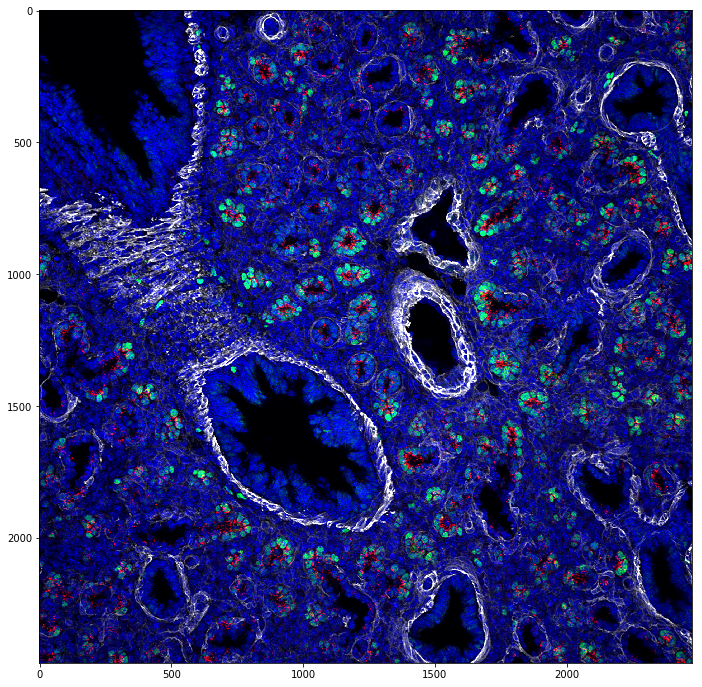

In [19]:
fig = plt.figure(figsize=fig_size)
plt.imshow(img_rgb)

In [20]:
# get the blue mask, and the white mask (to exclude these, they are too bright)
b_mask = color_utils.create_mask(img_hsv, colors=['blue'])
wb_mask = color_utils.create_mask(img_hsv, colors=['white', 'white_blue'])

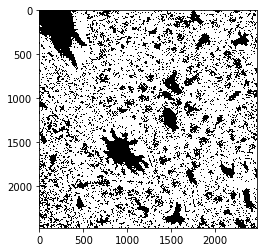

In [21]:
plt.imshow(b_mask, cmap='gray')

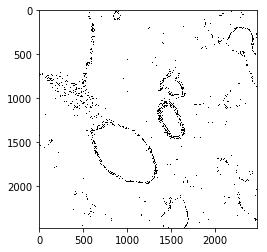

In [22]:
plt.imshow(~wb_mask, cmap='gray')

In [23]:
combined_mask = np.bitwise_and(b_mask, ~wb_mask)

In [24]:
img_v_b_filtered = cv2.bitwise_and(img_v, img_v, mask=combined_mask)

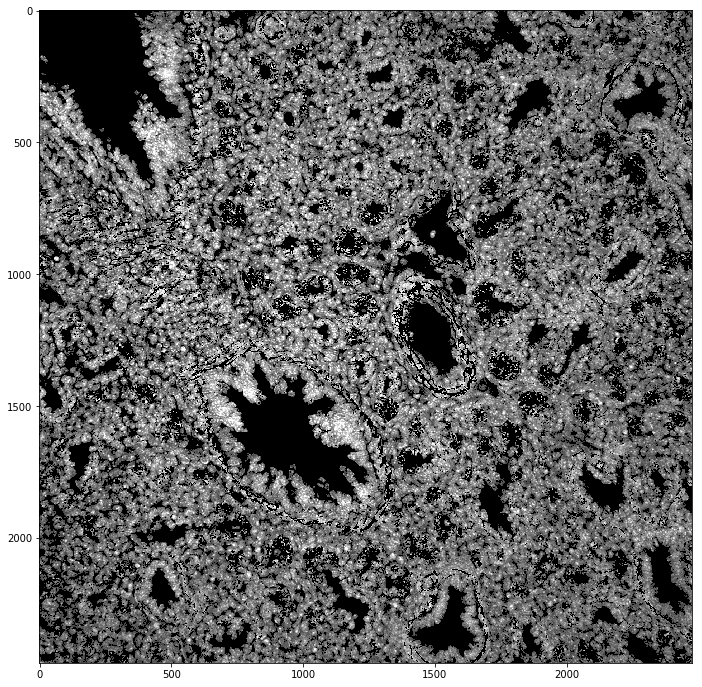

In [25]:
fig = plt.figure(figsize=fig_size)
plt.imshow(img_v_b_filtered, cmap='gray')

In [27]:
# get basic stats from non-zero pixels to exclude any remaining outliers
med = np.median(img_v_b_filtered[img_v_b_filtered > 0])
print(med)

121.0


In [28]:
# this step seems necessary
# we raise the "floor" so our gaussian fit routine doesn't get 
# confused about the real data we want to fit
tmp_img_filled = img_v_b_filtered.copy()
tmp_img_filled[tmp_img_filled <= med/2.0] = int(med/2.0)

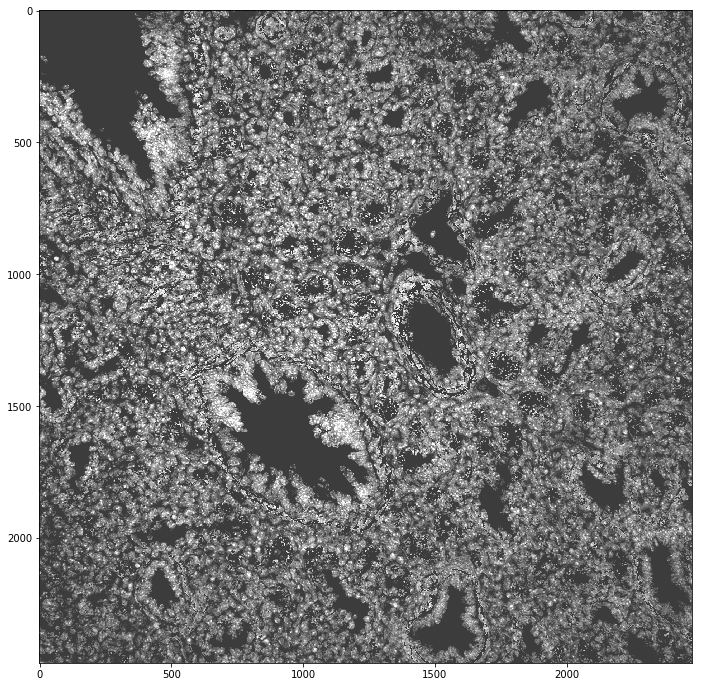

In [29]:
fig = plt.figure(figsize=fig_size)
plt.imshow(tmp_img_filled, cmap='gray', vmin=0, vmax=255)

In [30]:
params = fitgaussian(tmp_img_filled)
fit = gaussian(*params)

In [33]:
non_uni_field = fit(*np.indices(tmp_img_filled.shape))

In [34]:
non_uni_field.shape

(2475, 2475)

In [35]:
non_uni_field.min(), non_uni_field.max()

(81.17399239421184, 120.95099911550678)

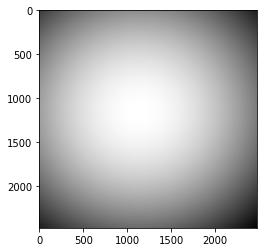

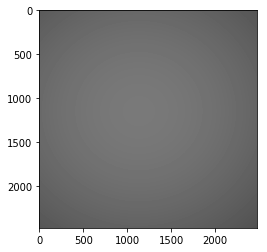

In [36]:
plt.imshow(non_uni_field, cmap='gray')
plt.show()
plt.imshow(non_uni_field, cmap='gray', vmin=0, vmax=255)
plt.show()

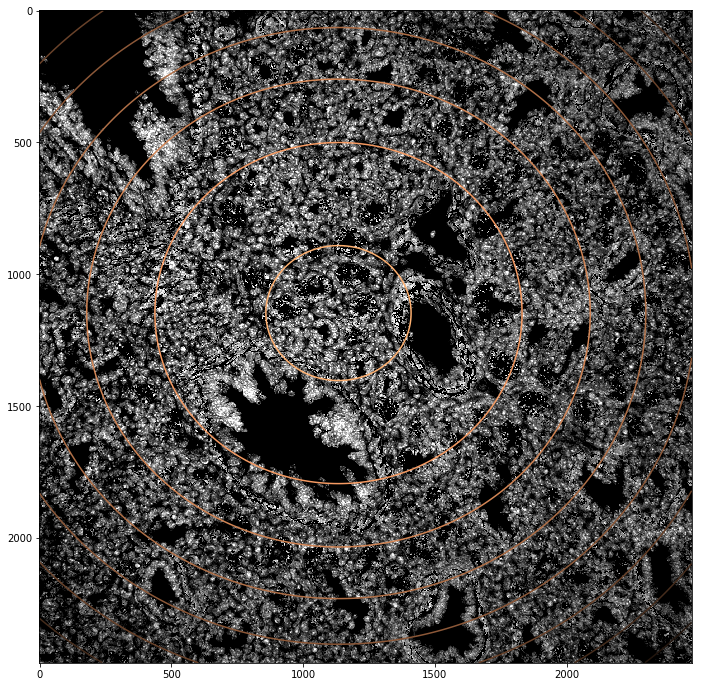

In [39]:
fig = plt.figure(figsize=fig_size)
plt.imshow(tmp_img_filled, cmap='gray')
plt.contour(non_uni_field, cmap=plt.cm.copper)
ax = plt.gca()
(height, x, y, width_x, width_y) = params

In [40]:
non_uni_field = non_uni_field.round().astype(np.uint8)

In [41]:
non_uni_field.max()

121

In [42]:
field_corr = ~non_uni_field

In [43]:
field_corr -= field_corr.min()

In [44]:
field_corr.min(), field_corr.max()

(0, 40)

In [45]:
field_corr

array([[31, 31, 31, ..., 35, 35, 35],
       [31, 31, 31, ..., 35, 35, 35],
       [31, 31, 31, ..., 35, 35, 35],
       ...,
       [35, 35, 35, ..., 40, 40, 40],
       [35, 35, 35, ..., 40, 40, 40],
       [35, 35, 35, ..., 40, 40, 40]], dtype=uint8)

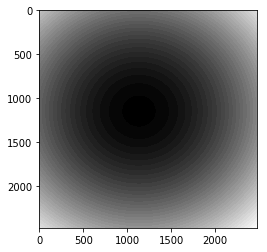

In [47]:
plt.imshow(field_corr, cmap='gray', vmin=0, vmax=field_corr.max())
plt.show()

In [48]:
img_v_corr = img_v.copy().astype(np.uint16)

In [49]:
img_v_corr += field_corr

In [50]:
img_v_corr.min(), img_v_corr.max()

(0, 294)

In [51]:
img_v_corr[img_v_corr > 255] = 255

In [52]:
img_v_corr = img_v_corr.astype(np.uint8)

In [53]:
img_hsv_corr = img_hsv.copy()
img_hsv_corr[:, :, 2] = img_v_corr

### Compare original vs corrected

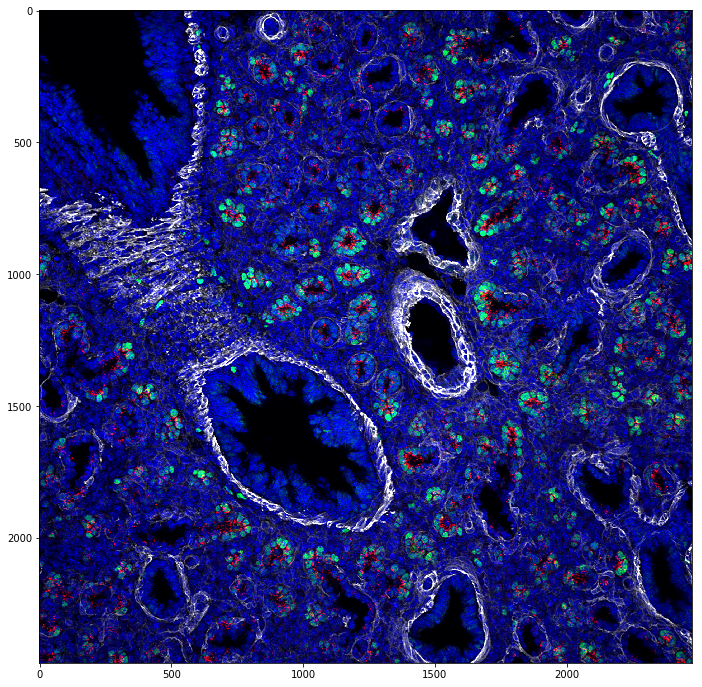

In [54]:
fig = plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

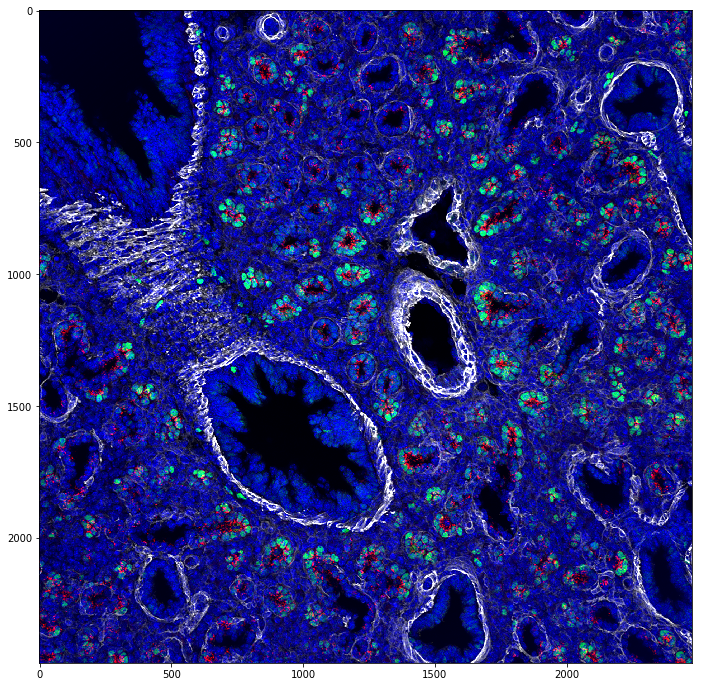

In [55]:
fig = plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(img_hsv_corr, cv2.COLOR_HSV2RGB))

### Repair black, empty space regions

The results are good thus far, but now we have modifed the black empty space to be brighter. Maybe extract the original black regions and put those values back?

In [56]:
black_mask = color_utils.create_mask(img_hsv, colors=['black'])

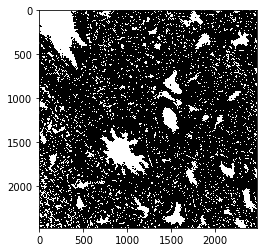

In [57]:
plt.imshow(black_mask, cmap='gray')

In [58]:
img_hsv_corr_corr = img_hsv_corr.copy()
img_hsv_corr_corr[black_mask > 0, 2] = img_hsv[black_mask > 0, 2]

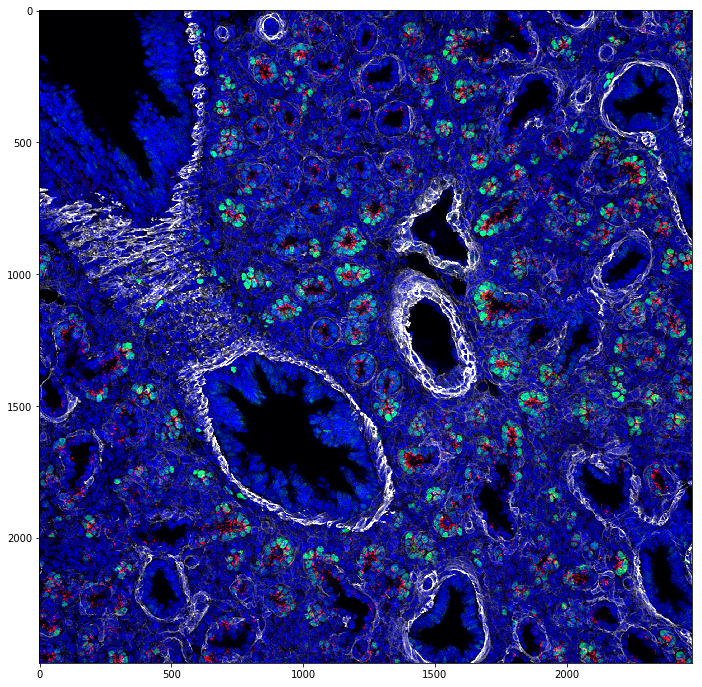

In [59]:
fig = plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(img_hsv_corr_corr, cv2.COLOR_HSV2RGB))